In [32]:
from Game.ping_pong import PingPong
from sklearn.neural_network import MLPClassifier
import numpy as np
from Game.agent import Agent

n_actions = 2

mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    warm_start=True,  # keep progress between .fit(...) calls
    max_iter=1,  # make only 1 iteration on each .fit(...)
)
# initialize agent to the dimension of state an amount of actions

game = PingPong(visible = False)
print(game.reset())
s, reward , is_end_game = game.reset()
mlp_classifier.fit([s]*n_actions, range(n_actions))

([0.0, 0.5, 0.99, 0.5, 0.5, 0.5, 0.24248096254497292, 0.24248096254497292], (0.0, 0), False)


/home/wer/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [33]:

def policy_bot(state):
    probs = mlp_classifier.predict_proba([state])[0]
    action = np.random.choice([0,1], p=probs)
    return action
bot = Agent(policy_bot)

def policy_random_bot(state):
    action = np.random.choice([0,1])
    return 0
random_bot = Agent(policy_random_bot)

In [34]:
def generate_session():
    
    states, actions = [], []
    total_reward_1 = 0
    total_reward_2 = 0

    s, r, is_end_game = game.reset()

    while True:

        # predict array of action probabilities
        
        action_1 = bot.get_action(s)
        action_2 = random_bot.get_action(s)
        new_s, r, is_end_game = game.game_step(action_1,action_2)
        
        # record sessions like you did before
        states.append(s)
        actions.append(action_1)
        total_reward_1 += r[0]
        total_reward_2 += r[1]

        s = new_s
        
        if is_end_game == True:
            break
    return states, actions, total_reward_1

In [35]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, q = percentile)

    id = np.where(rewards_batch >= reward_threshold)
    
    elite_states = np.concatenate(np.array(states_batch)[id])
    elite_actions = np.concatenate(np.array(actions_batch)[id])

    return elite_states, elite_actions

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = -6172.894, threshold=-3190.720


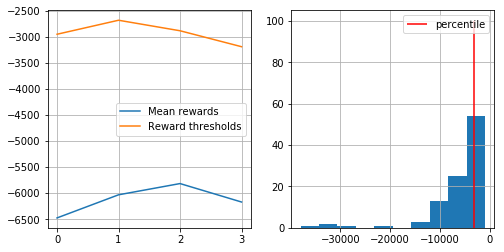

In [ ]:
n_sessions = 100
percentile = 70
log = []

for _ in range(100):
    # generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    print((states_batch, actions_batch, rewards_batch))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch,  percentile = percentile )

    mlp_classifier.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])


In [31]:
game.quit()